<a href="https://colab.research.google.com/github/dorobat-diana/LicentaAi/blob/main/siameseFintunning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading the fine-tuned base model...
Base model loaded successfully.
Feature extractor created using layer: 'global_average_pooling2d_1' and frozen.

Building Siamese model with improved head...


Model: "siamese_network_v2_corrected_lambda"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_A       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_B       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extractor_… │ (None, 1280)      │  2,257,984 │ input_image_A[0]… │
│ (Functional)        │                   │            │ input_image_B[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L1_distance         │ (None, 1)         │          0 │ feature_extracto… │
│ (Lambda)            │                   │            │ feature_extracto… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_1        │ (None, 128)       │        256 │ L1_distance[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout_1      │ (None, 128)       │          0 │ head_dense_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_2        │ (None, 64)        │      8,256 │ head_dropout_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout_2      │ (None, 64)        │          0 │ head_dense_2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_predict… │ (None, 1)         │         65 │ head_dropout_2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,266,561 (8.65 MB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Preparing training data...
Number of training pairs: 12200

Preparing validation data...
Number of validation pairs: 12200

Compiling Siamese model...

Training Siamese model...
Epoch 1/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 86s 192ms/step - accuracy: 0.4926 - loss: 19.1089 - val_accuracy: 0.5000 - val_loss: 0.7422
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 62s 163ms/step - accuracy: 0.5116 - loss: 8.4255 - val_accuracy: 0.5000 - val_loss: 0.9252
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 62s 163ms/step - accuracy: 0.5050 - loss: 4.2805 - val_accuracy: 0.5000 - val_loss: 0.9760
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 62s 164ms/step - accuracy: 0.4946 - loss: 2.2842 - val_accuracy: 0.5000 - val_loss: 0.6717
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 62s 163ms/step - accuracy: 0.5208 - loss: 1.3040 - val_accuracy: 0.5001 - val_loss: 0.6704
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 62s 164ms/step - accuracy: 0.5233 - loss: 0.9891 - val_accuracy: 0.5021 - val_loss: 0.6709
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━

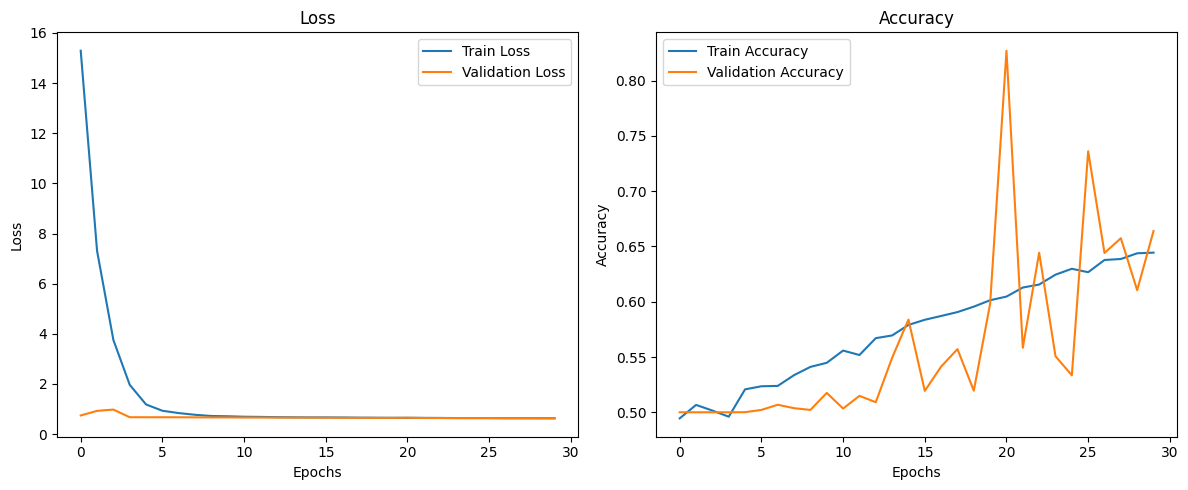

Trained Siamese model (Phase 1 - Head Training with corrected Lambda) saved.

Example predictions on validation pairs (using the trained model):
Pair: (3fc04503bf.jpg, 4ba156fecf.jpg), Actual Label: 1.0, Predicted Similarity: 0.4787 (Same class)
Pair: (4b1645e2e1.jpg, ef4dd2fc47.jpg), Actual Label: 0.0, Predicted Similarity: 0.3086 (Different classes)

--- Script Finished ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from google.colab import drive

# --- 0. Mount Google Drive ---
try:
    drive.mount('/content/drive')
except:
    print("Google Drive already mounted or mount failed.")

# --- 1. Configuration & Paths ---
BASE_MODEL_PATH = '/content/drive/MyDrive/ColabNotebooks/results/MobileNetV2_FamousPlaces/phase3_with_dropout_l2.keras'
TRAIN_DIR = '/content/drive/MyDrive/ColabNotebooks/data/famous_places/split/train'
TEST_DIR = '/content/drive/MyDrive/ColabNotebooks/data/famous_places/split/test' # For validation pairs

FEATURE_LAYER_NAME = 'global_average_pooling2d_1'

IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
BATCH_SIZE = 32
EPOCHS = 30 # Increased epochs slightly as the head is more complex
LEARNING_RATE = 1e-4 # Start with this, might need adjustment

# --- 2. Load Pre-trained Model and Create Feature Extractor ---
print("Loading the fine-tuned base model...")
try:
    full_model = load_model(BASE_MODEL_PATH)
    print("Base model loaded successfully.")

    try:
        feature_output = full_model.get_layer(FEATURE_LAYER_NAME).output
        feature_extractor = Model(inputs=full_model.input, outputs=feature_output, name="feature_extractor_functional")
        feature_extractor.trainable = False # Keep the feature extractor frozen
        print(f"Feature extractor created using layer: '{FEATURE_LAYER_NAME}' and frozen.")
    except ValueError as e:
        print(f"Error getting layer '{FEATURE_LAYER_NAME}': {e}")
        raise ValueError(f"Feature extractor could not be created. Please ensure '{FEATURE_LAYER_NAME}' is correct.")

except Exception as e:
    print(f"Error loading base model or creating feature extractor: {e}")
    raise

# --- 3. Build Siamese Network with a More Capable Head ---
def build_siamese_model_v2(input_shape, feature_extractor_model): # Ensure this is the version used
    """
    Builds the Siamese network model with a more complex head.
    """
    input_a = Input(shape=input_shape, name="input_image_A")
    input_b = Input(shape=input_shape, name="input_image_B")

    processed_a = feature_extractor_model(input_a)
    processed_b = feature_extractor_model(input_b)

    # --- MODIFICATION FOR CORRECT SAVING ---
    distance_layer = Lambda(
        lambda tensors: K.sum(K.abs(tensors[0] - tensors[1]), axis=1, keepdims=True),
        output_shape=(1,), # <<< ADD THIS!
        name="L1_distance"
    )
    distance = distance_layer([processed_a, processed_b])

    x = Dense(128, activation='relu', name="head_dense_1")(distance)
    x = Dropout(0.3, name="head_dropout_1")(x)
    x = Dense(64, activation='relu', name="head_dense_2")(x)
    x = Dropout(0.3, name="head_dropout_2")(x)
    prediction = Dense(1, activation='sigmoid', name="similarity_prediction")(x)

    siamese_net = Model(inputs=[input_a, input_b], outputs=prediction, name="siamese_network_v2_corrected_lambda") # Optional: new name
    return siamese_net


print("\nBuilding Siamese model with improved head...")
siamese_model = build_siamese_model_v2(IMG_SHAPE, feature_extractor)
siamese_model.summary() # Observe the increased trainable parameters now

# --- 4. Prepare Data (Assuming functions from previous version are available and correct) ---
def list_image_files_and_labels(directory):
    image_paths_by_label = {}
    label_to_name = {}
    name_to_label = {}
    current_label_id = 0
    class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if class_name not in name_to_label:
            name_to_label[class_name] = current_label_id
            label_to_name[current_label_id] = class_name
            image_paths_by_label[current_label_id] = []
            current_label_id += 1
        label_id = name_to_label[class_name]
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths_by_label[label_id].append(os.path.join(class_dir, fname))
    all_unique_labels = sorted(list(label_to_name.keys()))
    return image_paths_by_label, label_to_name, name_to_label, all_unique_labels

def create_image_pairs(image_paths_by_label, all_unique_labels, num_pairs_per_anchor=1):
    pair_paths = []
    pair_labels = []
    if not all_unique_labels or not image_paths_by_label: return np.array(pair_paths), np.array(pair_labels)

    all_images_flat = [{'path': p, 'label': lbl} for lbl, paths in image_paths_by_label.items() for p in paths]
    if not all_images_flat: return np.array(pair_paths), np.array(pair_labels)

    random.shuffle(all_images_flat)

    for anchor_data in all_images_flat:
        anchor_path, anchor_label = anchor_data['path'], anchor_data['label']

        # Create positive pairs
        positive_candidates = [p for p in image_paths_by_label.get(anchor_label, []) if p != anchor_path]
        if positive_candidates:
            selected_positives = random.sample(positive_candidates, min(len(positive_candidates), num_pairs_per_anchor))
            for positive_path in selected_positives:
                pair_paths.append([anchor_path, positive_path])
                pair_labels.append(1.0)

        # Create negative pairs
        negative_label_choices = [l for l in all_unique_labels if l != anchor_label]
        if negative_label_choices:
            for _ in range(num_pairs_per_anchor): # Try to balance with num_pairs_per_anchor
                negative_label = random.choice(negative_label_choices)
                negative_candidates = image_paths_by_label.get(negative_label, [])
                if negative_candidates:
                    negative_path = random.choice(negative_candidates)
                    pair_paths.append([anchor_path, negative_path])
                    pair_labels.append(0.0)

    # Shuffle the final pairs
    combined = list(zip(pair_paths, pair_labels))
    random.shuffle(combined)
    if combined:
        pair_paths, pair_labels = zip(*combined)
    else: # Handle case where no pairs were generated
        return np.array([]), np.array([])


    return np.array(pair_paths), np.array(pair_labels)


def load_and_preprocess_image_tf(path_tensor, img_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    img = tf.io.read_file(path_tensor)
    try:
        img = tf.image.decode_image(img, channels=img_shape[2], expand_animations=False) # More general decoder
    except tf.errors.InvalidArgumentError as e:
        # This might happen if the file is not a valid image or format not supported well by decode_image
        tf.print(f"Warning: Could not decode image {path_tensor}. Error: {e}. Returning zeros.")
        return tf.zeros(img_shape, dtype=tf.float32)

    # Ensure the decoded image has 3 dimensions [height, width, channels]
    if len(img.shape) != 3 or img.shape[2] != img_shape[2]:
        tf.print(f"Warning: Image {path_tensor} has unexpected shape {img.shape}. Converting to RGB and resizing or returning zeros.")
        if img.shape[2] == 1: # Grayscale
            img = tf.image.grayscale_to_rgb(img)
        elif img.shape[2] == 4: # RGBA
            img = img[:,:,:3] # Take RGB
        else: # Other problematic shapes
            return tf.zeros(img_shape, dtype=tf.float32)


    img = tf.image.resize(img, [img_shape[0], img_shape[1]])
    img = tf.cast(img, tf.float32) # Ensure float32 before preprocessing
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img

def create_tf_dataset(pair_paths, pair_labels, batch_size, img_shape):
    if len(pair_paths) == 0:
        print("Warning: pair_paths is empty. Cannot create tf.data.Dataset.")
        return None

    path1_list = [p[0] for p in pair_paths]
    path2_list = [p[1] for p in pair_paths]

    dataset = tf.data.Dataset.from_tensor_slices(((path1_list, path2_list), pair_labels))

    def _preprocess_pair(paths, label):
        path1, path2 = paths
        img1 = load_and_preprocess_image_tf(path1, img_shape)
        img2 = load_and_preprocess_image_tf(path2, img_shape)
        return (img1, img2), label

    dataset = dataset.shuffle(buffer_size=len(pair_labels))
    dataset = dataset.map(_preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

print("\nPreparing training data...")
train_images_by_label, _, _, train_unique_labels = list_image_files_and_labels(TRAIN_DIR)
train_pair_paths, train_pair_labels = create_image_pairs(train_images_by_label, train_unique_labels, num_pairs_per_anchor=2) # Generate more pairs
print(f"Number of training pairs: {len(train_pair_paths)}")
train_dataset = create_tf_dataset(train_pair_paths, train_pair_labels, BATCH_SIZE, IMG_SHAPE)

print("\nPreparing validation data...")
test_images_by_label, _, _, test_unique_labels = list_image_files_and_labels(TEST_DIR)
val_pair_paths, val_pair_labels = create_image_pairs(test_images_by_label, test_unique_labels, num_pairs_per_anchor=2)
print(f"Number of validation pairs: {len(val_pair_paths)}")
val_dataset = create_tf_dataset(val_pair_paths, val_pair_labels, BATCH_SIZE, IMG_SHAPE)


# --- 5. Compile and Train the Siamese Model ---
if train_dataset and val_dataset:
    print("\nCompiling Siamese model...")
    siamese_model.compile(loss='binary_crossentropy',
                          optimizer=Adam(learning_rate=LEARNING_RATE),
                          metrics=['accuracy'])

    print("\nTraining Siamese model...")
    # Add a callback for early stopping if validation loss doesn't improve
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = siamese_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping]
    )

    # Plot training history
    if history and history.history:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Training was skipped or history is not available.")


    # Save the trained Siamese model (optional)
    siamese_model.save('/content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_v2_phase1_corrected.keras')
    print("Trained Siamese model (Phase 1 - Head Training with corrected Lambda) saved.")
else:
    print("Training and/or validation dataset could not be created. Skipping training.")


# --- 6. How to Use for New Landmark Identification (Conceptual) ---
# (Same as before)

# Example of making a single prediction (after model is trained)
def predict_similarity(img_path1, img_path2, model, img_shape):
    # Ensure model is available
    if model is None:
        print("Model not available for prediction.")
        return None

    img1_tensor = load_and_preprocess_image_tf(tf.constant(img_path1), img_shape)
    img2_tensor = load_and_preprocess_image_tf(tf.constant(img_path2), img_shape)

    # Check if tensors are valid (not all zeros due to loading error)
    if tf.reduce_sum(img1_tensor) == 0 or tf.reduce_sum(img2_tensor) == 0:
        print(f"Warning: One or both images ({os.path.basename(img_path1)}, {os.path.basename(img_path2)}) might not have loaded correctly for prediction.")
        # return None # Or handle as appropriate

    img1_batch = tf.expand_dims(img1_tensor, axis=0) # Use tf.expand_dims
    img2_batch = tf.expand_dims(img2_tensor, axis=0)

    try:
        prediction = model.predict([img1_batch, img2_batch], verbose=0) # verbose=0 to suppress progress bar
        return prediction[0][0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None


# After training, you can test with a few examples:
if val_pair_paths is not None and len(val_pair_paths) > 0 and siamese_model is not None:
    print("\nExample predictions on validation pairs (using the trained model):")

    # Find a positive pair
    positive_indices = [i for i, label in enumerate(val_pair_labels) if label == 1.0]
    if positive_indices:
        idx = random.choice(positive_indices)
        path1, path2 = val_pair_paths[idx]
        label = val_pair_labels[idx]
        sim = predict_similarity(path1, path2, siamese_model, IMG_SHAPE)
        if sim is not None:
            print(f"Pair: ({os.path.basename(path1)}, {os.path.basename(path2)}), Actual Label: {label}, Predicted Similarity: {sim:.4f} (Same class)")
    else:
        print("No positive validation pairs found for example prediction.")

    # Find a negative pair
    negative_indices = [i for i, label in enumerate(val_pair_labels) if label == 0.0]
    if negative_indices:
        idx = random.choice(negative_indices)
        path1, path2 = val_pair_paths[idx]
        label = val_pair_labels[idx]
        sim = predict_similarity(path1, path2, siamese_model, IMG_SHAPE)
        if sim is not None:
            print(f"Pair: ({os.path.basename(path1)}, {os.path.basename(path2)}), Actual Label: {label}, Predicted Similarity: {sim:.4f} (Different classes)")
    else:
        print("No negative validation pairs found for example prediction.")
else:
    print("\nSkipping example predictions as validation pairs or model is not available.")


print("\n--- Script Finished ---")


In [ ]:
siamese_model.save('/content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_v2.keras')
print("Trained Siamese model saved.")

Trained Siamese model saved.




--- Starting Phase 2: Fine-tuning with unfrozen base layers ---
Continuing with the 'siamese_model' already in memory.

Original Siamese model summary (before unfreezing for phase 2):


Model: "siamese_network_v2_corrected_lambda"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_A       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_B       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extractor_… │ (None, 1280)      │  2,257,984 │ input_image_A[0]… │
│ (Functional)        │                   │            │ input_image_B[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L1_distance         │ (None, 1)         │          0 │ feature_extracto… │
│ (Lambda)            │                   │            │ feature_extracto… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_1        │ (None, 128)       │        256 │ L1_distance[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout_1      │ (None, 128)       │          0 │ head_dense_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_2        │ (None, 64)        │      8,256 │ head_dropout_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout_2      │ (None, 64)        │          0 │ head_dense_2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_predict… │ (None, 1)         │         65 │ head_dropout_2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,283,717 (8.71 MB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 17,156 (67.02 KB)

Found feature_extractor layer in Siamese model: 'feature_extractor_functional'
Unfreezing the top 10 layers of 'feature_extractor_functional'...
Unfroze 7 non-BatchNormalization layers within 'feature_extractor_functional'.

Siamese model summary AFTER unfreezing for phase 2 (check trainable params):


Model: "siamese_network_v2_corrected_lambda"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_A       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_B       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_extractor_… │ (None, 1280)      │  2,257,984 │ input_image_A[0]… │
│ (Functional)        │                   │            │ input_image_B[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L1_distance         │ (None, 1)         │          0 │ feature_extracto… │
│ (Lambda)            │                   │            │ feature_extracto… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_1        │ (None, 128)       │        256 │ L1_distance[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout_1      │ (None, 128)       │          0 │ head_dense_1[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dense_2        │ (None, 64)        │      8,256 │ head_dropout_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head_dropout_2      │ (None, 64)        │          0 │ head_dense_2[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_predict… │ (None, 1)         │         65 │ head_dropout_2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,283,717 (8.71 MB)

 Trainable params: 734,017 (2.80 MB)

 Non-trainable params: 1,532,544 (5.85 MB)

 Optimizer params: 17,156 (67.02 KB)


Re-compiling Siamese model for phase 2 fine-tuning...
Siamese model re-compiled.

Starting Phase 2 training (fine-tuning top layers)...
Epoch 1/25
382/382 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6620 - loss: 0.6249
Epoch 1: val_loss improved from inf to 0.61179, saving model to /content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_phase2_toplayers.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 89s 194ms/step - accuracy: 0.6620 - loss: 0.6249 - val_accuracy: 0.6893 - val_loss: 0.6118 - learning_rate: 2.0000e-05
Epoch 2/25
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6711 - loss: 0.6057
Epoch 2: val_loss improved from 0.61179 to 0.59930, saving model to /content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_phase2_toplayers.keras
382/382 ━━━━━━━━━━━━━━━━━━━━ 62s 164ms/step - accuracy: 0.6711 - loss: 0.6057 - val_accuracy: 0.6882 - val_loss: 0.5993 - learning_rate: 2.0000e-05
Epoch 3/25
381/382 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 

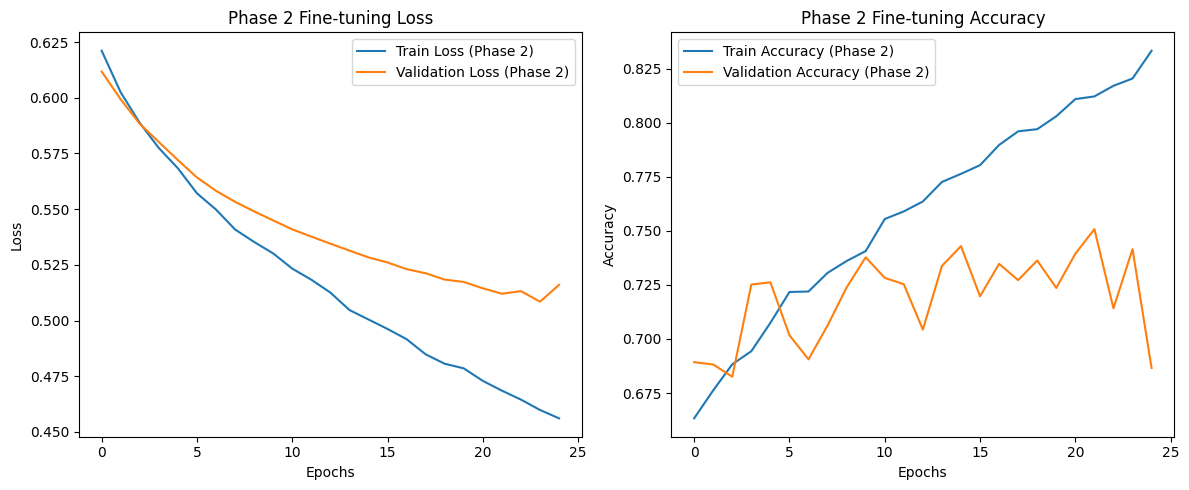

Phase 2 fine-tuned Siamese model saved to /content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_phase2_toplayers.keras (by ModelCheckpoint).
This model was built with the corrected Lambda layer definition, so it should load without issues.
Loading the best model from Phase 2 fine-tuning...


ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().

In [ ]:
# --- Continuation: Fine-tune with Unfrozen Layers ---

print("\n\n--- Starting Phase 2: Fine-tuning with unfrozen base layers ---")

# Configuration for this phase
LEARNING_RATE_PHASE2 = 2e-5 # Lower learning rate for fine-tuning
EPOCHS_PHASE2 = 25
N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE = 10 # Number of layers to unfreeze from the end of the feature_extractor
SIAMESE_MODEL_PHASE2_PATH = '/content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_phase2_toplayers.keras'

# The siamese_model variable should still hold the model from the previous training phase.
if 'siamese_model' not in locals() or siamese_model is None:
    print("Error: 'siamese_model' not found. Please ensure the previous training phase has completed and 'siamese_model' is in memory.")
    # As a fallback, you might try to load the last saved model,
    # but ensure it was saved with the corrected Lambda (output_shape=(1,))
    # For example:
    # print("Attempting to load previously saved model...")
    # try:
    #     # Make sure this path points to a model saved WITH output_shape in Lambda
    #     siamese_model = load_model('/content/drive/MyDrive/ColabNotebooks/results/siamese_mobilenetv2_landmark_model_v2_phase1_corrected.keras')
    #     print("Previously saved model loaded.")
    # except Exception as e:
    #     print(f"Could not load previous model: {e}. Cannot continue fine-tuning.")
    #     raise
else:
    print("Continuing with the 'siamese_model' already in memory.")

print("\nOriginal Siamese model summary (before unfreezing for phase 2):")
siamese_model.summary()

# Unfreeze layers in the feature_extractor part of the Siamese model
try:
    # The feature_extractor was named "feature_extractor_functional"
    # When used in the siamese_model, it becomes a layer with that name.
    feature_extractor_in_siamese = siamese_model.get_layer("feature_extractor_functional")
    print(f"Found feature_extractor layer in Siamese model: '{feature_extractor_in_siamese.name}'")

    if N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE > 0:
        print(f"Unfreezing the top {N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE} layers of '{feature_extractor_in_siamese.name}'...")

        # Important: Set the entire feature_extractor_in_siamese layer (which is a Model)
        # to non-trainable first, then selectively unfreeze its internal layers.
        # This prevents unintended layers from becoming trainable if they were already.
        # However, if it was already frozen, this doesn't change much.
        # The key is to iterate its *internal* layers.

        # Ensure that the internal layers of feature_extractor_in_siamese can be set
        if not hasattr(feature_extractor_in_siamese, 'layers'):
            raise ValueError(f"Layer '{feature_extractor_in_siamese.name}' is not a Keras Model and has no 'layers' attribute.")

        # Freeze all internal layers of the feature_extractor_in_siamese first
        for layer in feature_extractor_in_siamese.layers:
            layer.trainable = False

        unfrozen_count = 0
        # Unfreeze the top N layers (excluding BatchNormalization)
        for layer in feature_extractor_in_siamese.layers[-N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE:]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
                unfrozen_count +=1
            # print(f"Layer '{layer.name}' trainable status: {layer.trainable}")
        print(f"Unfroze {unfrozen_count} non-BatchNormalization layers within '{feature_extractor_in_siamese.name}'.")
        if unfrozen_count == 0 and N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE > 0:
             print(f"WARNING: No layers were unfrozen. Check N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE ({N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE}) or if all top layers are BatchNormalization.")
    else:
        print(f"N_TOP_LAYERS_TO_UNFREEZE_SIAMESE_BASE is 0. Keeping '{feature_extractor_in_siamese.name}' frozen.")
        feature_extractor_in_siamese.trainable = False # Ensure it stays frozen if N=0

    print("\nSiamese model summary AFTER unfreezing for phase 2 (check trainable params):")
    siamese_model.summary()

except Exception as e:
    print(f"Error during unfreezing process for phase 2: {e}")
    raise

# Re-compile the Siamese model with the new trainability settings and a lower learning rate
print("\nRe-compiling Siamese model for phase 2 fine-tuning...")
siamese_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2), # Use the new, very low learning rate
    metrics=['accuracy']
)
print("Siamese model re-compiled.")

# Continue training (Phase 2)
# Data (train_dataset, val_dataset) should still be available from the previous cells.
if 'train_dataset' not in locals() or 'val_dataset' not in locals():
    print("Error: Training/Validation dataset not found. Please ensure data preparation has been run.")
    raise
else:
    print("\nStarting Phase 2 training (fine-tuning top layers)...")

    early_stopping_phase2 = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, # More patience for fine-tuning
        restore_best_weights=True,
        verbose=1
    )
    model_checkpoint_phase2 = tf.keras.callbacks.ModelCheckpoint(
        SIAMESE_MODEL_PHASE2_PATH,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    reduce_lr_phase2 = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    history_phase2 = siamese_model.fit(
        train_dataset, # Assuming train_dataset and val_dataset are still in memory
        epochs=EPOCHS_PHASE2,
        validation_data=val_dataset,
        callbacks=[early_stopping_phase2, model_checkpoint_phase2, reduce_lr_phase2]
    )

    # Plot training history for phase 2
    if history_phase2 and history_phase2.history:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history_phase2.history['loss'], label='Train Loss (Phase 2)')
        plt.plot(history_phase2.history['val_loss'], label='Validation Loss (Phase 2)')
        plt.title('Phase 2 Fine-tuning Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history_phase2.history['accuracy'], label='Train Accuracy (Phase 2)')
        plt.plot(history_phase2.history['val_accuracy'], label='Validation Accuracy (Phase 2)')
        plt.title('Phase 2 Fine-tuning Accuracy')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/ColabNotebooks/results/training_history_phase2_toplayers.png')
        plt.show()

    print(f"Phase 2 fine-tuned Siamese model saved to {SIAMESE_MODEL_PHASE2_PATH} (by ModelCheckpoint).")
    print("This model was built with the corrected Lambda layer definition, so it should load without issues.")

    # Load the best model saved by ModelCheckpoint for any immediate post-training use
    print("Loading the best model from Phase 2 fine-tuning...")
    siamese_model = load_model(SIAMESE_MODEL_PHASE2_PATH) # No custom_objects needed if Lambda was corrected
    print("Best Phase 2 model loaded.")

    # You can run predictions with this 'siamese_model' if needed
    if val_pair_paths is not None and len(val_pair_paths) > 0 and siamese_model is not None:
        print("\nExample predictions on validation pairs (using the Phase 2 fine-tuned model):")

        positive_indices = [i for i, label in enumerate(val_pair_labels) if label == 1.0]
        if positive_indices:
            idx = random.choice(positive_indices)
            path1, path2 = val_pair_paths[idx]
            label = val_pair_labels[idx]
            sim = predict_similarity(path1, path2, siamese_model, IMG_SHAPE) # predict_similarity should be defined
            if sim is not None:
                print(f"Pair: ({os.path.basename(path1)}, {os.path.basename(path2)}), Actual Label: {label}, Predicted Similarity: {sim:.4f} (Same class)")

        negative_indices = [i for i, label in enumerate(val_pair_labels) if label == 0.0]
        if negative_indices:
            idx = random.choice(negative_indices)
            path1, path2 = val_pair_paths[idx]
            label = val_pair_labels[idx]
            sim = predict_similarity(path1, path2, siamese_model, IMG_SHAPE)
            if sim is not None:
                print(f"Pair: ({os.path.basename(path1)}, {os.path.basename(path2)}), Actual Label: {label}, Predicted Similarity: {sim:.4f} (Different classes)")
    else:
        print("\nSkipping example predictions as validation pairs or model is not available for Phase 2.")

print("\n--- Phase 2 Fine-tuning Script Finished ---")